# Characterizing spike-time oscillations in premotor cortex

This notebook demonstrates how to reproduce the essential elements of Fig. 5 in:

> [**Discovering precise temporal patterns in large-scale neural recordings through robust and interpretable time warping**](https://doi.org/10.1101/661165). Williams AH, Poole B, Maheswaranathan N, Dhawale AK, Fisher T, Wilson CD, Brann DH, Trautmann E, Ryu S, Shusterman R, Rinberg D, Ölveczky BP, Shenoy KV, Ganguli S (2019). *bioRXiv*. 661165

These data were collected by Tucker Fisher & Eric Trautmann in Krishna Shenoy's lab. Spike times and pre-processed LFP are provided here; a more complete and fully documented data release is forthcoming. Further questions regarding these data should be directed to shenoy@stanford.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Hyperparameters for data preprocessing and models.

In [2]:
# Trial duration and bin size parameters.
TMIN = -400  # ms
TMAX = 100   # ms
BINSIZE = 5  # ms
NBINS = int((TMAX - TMIN) / BINSIZE)

# LFP parameters.
LOW_CUTOFF = 10  # Hz
HIGH_CUTOFF = 30  # Hz

# Hyperparameters for shift-only warping model.
SHIFT_SMOOTHNESS_REG = 0.5
SHIFT_WARP_REG = 1e-2
MAXLAG = 0.15

# Hyperparameters for linear warping model.
LINEAR_SMOOTHNESS_REG = 1.0
LINEAR_WARP_REG = 0.065

### Load data.

Spike times here represent simple threshold-crossing events—no spike sorting was performed.

All spike times are defined relative to "GO CUE".

In [3]:
from affinewarp import SpikeData

# Spike times.
S = dict(np.load("umi_spike_data.npz"))
data = SpikeData(
    trials=S["trials"],
    spiketimes=S["spiketimes"],
    neurons=S["unit_ids"],
    tmin=TMIN,
    tmax=TMAX,
)

# Bin and normalize (soft z-score) spike times.
binned = data.bin_spikes(NBINS)
binned = binned - binned.mean(axis=(0, 1), keepdims=True)
binned = binned / (1e-2 + binned.std(axis=(0, 1), keepdims=True))

# Crop spike times when visualizing rasters.
cropped_data = data.crop_spiketimes(TMIN, TMAX)

# Load LFP traces (n_trials x n_timebins). Crop traces to [TMIN, TMAX).
L = dict(np.load("umi_lfp_data.npz"))

#### Bandpass filter LFP.

In [4]:
# Define bandpass filtering function for LFP
from scipy.signal import butter, filtfilt, freqz

def bandpass(x, lowcut, highcut, fs, order=5, axis=-1, kind='butter'):
    """
    Bandpass filters analog time series.

    Parameters
    ----------
    x : ndarray
        Time series data
    lowcut : float
        Defines lower frequency cutoff (e.g. in Hz)
    highcut : float
        Defines upper frequency cutoff (e.g. in Hz)
    fs : float
        Sampling frequency (e.g. in Hz)
    order : int
        Filter order parameter
    kind : str
        Specifies the kind of filter
    axis : int
        Axis along which to bandpass filter data
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if kind == "butter":
        b, a = butter(order, [low, high], btype="band")
    else:
        raise ValueError("Filter kind not recognized.")
    return filtfilt(b, a, x, axis=axis)

In [5]:
# Load LFP.
L = dict(np.load("umi_lfp_data.npz"))

# Apply bandpass filter.
lfp = bandpass(L["lfp"], LOW_CUTOFF, HIGH_CUTOFF, L["sample_rate"])

# Crop LFP time base to match spike times.
tidx = (L["lfp_time"] >= TMIN) & (L["lfp_time"] < TMAX)
lfp = lfp[:, tidx]
lfp_time = L["lfp_time"][tidx]

# Z-score LFP.
lfp -= lfp.mean(axis=1, keepdims=True)
lfp /= lfp.std(axis=1, keepdims=True)

/Users/alex/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


### Fit warping models.

In [6]:
from affinewarp import ShiftWarping

# Specify model.
shift_model = ShiftWarping(
    smoothness_reg_scale=SHIFT_SMOOTHNESS_REG,
    warp_reg_scale=SHIFT_WARP_REG,
    maxlag=MAXLAG,
)

# Fit to binned spike times.
shift_model.fit(binned, iterations=50)

# Apply inverse warping functions to data.
shift_aligned_data = shift_model.transform(data).crop_spiketimes(TMIN, TMAX)

Loss: 0.93: 100%|██████████| 50/50 [00:03<00:00, 22.93it/s]


In [7]:
from affinewarp import PiecewiseWarping

# Specify model.
lin_model = PiecewiseWarping(
    n_knots=0,
    smoothness_reg_scale=LINEAR_SMOOTHNESS_REG,
    warp_reg_scale=LINEAR_WARP_REG
)

# Fit to binned spike times.
lin_model.fit(binned, iterations=50)

# Apply inverse warping functions to data.
linear_aligned_data = lin_model.transform(data).crop_spiketimes(TMIN, TMAX)

Loss improvement: 0.89%: 100%|██████████| 50/50 [00:39<00:00,  1.32it/s]


#### Compare optimization curves.

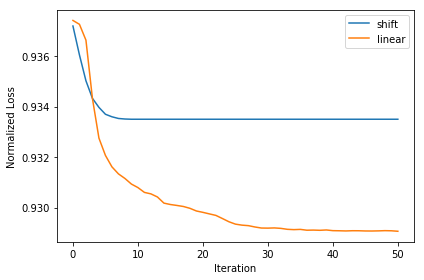

In [8]:
plt.plot(shift_model.loss_hist, label="shift")
plt.plot(lin_model.loss_hist, label="linear")
plt.xlabel("Iteration")
plt.ylabel("Normalized Loss")
plt.legend()
plt.tight_layout()

### Visualize raster plots

We visualize the first 30 multiunits. There are a total of 96 in this dataset.

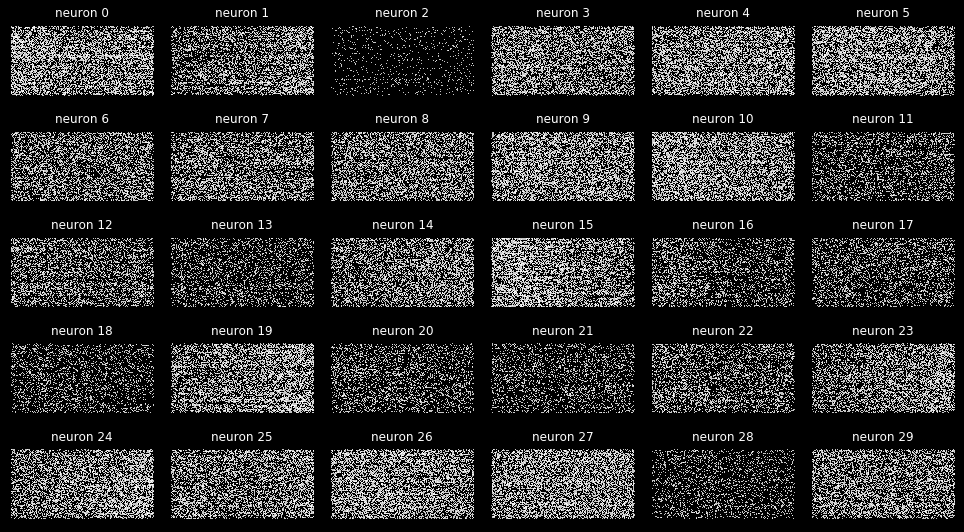

In [9]:
from affinewarp.visualization import rasters
rasters(cropped_data);

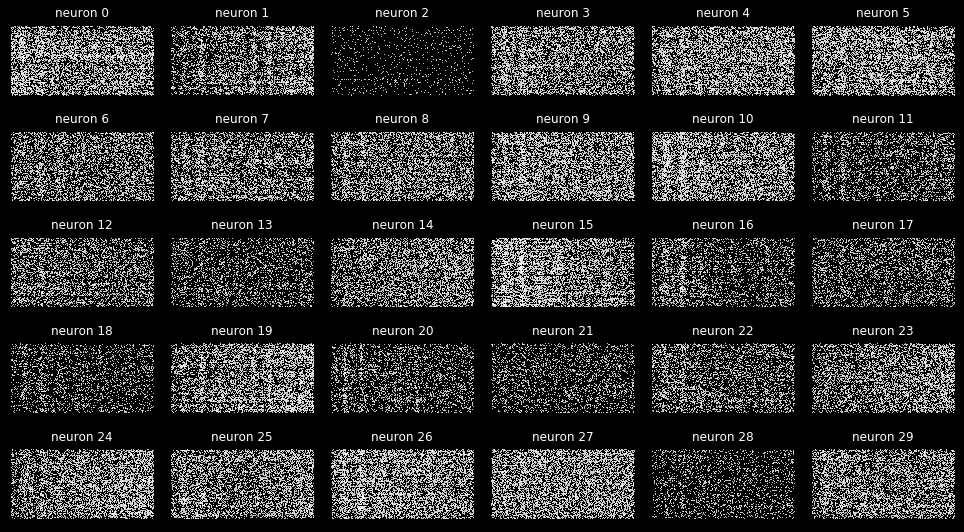

In [10]:
rasters(shift_aligned_data);

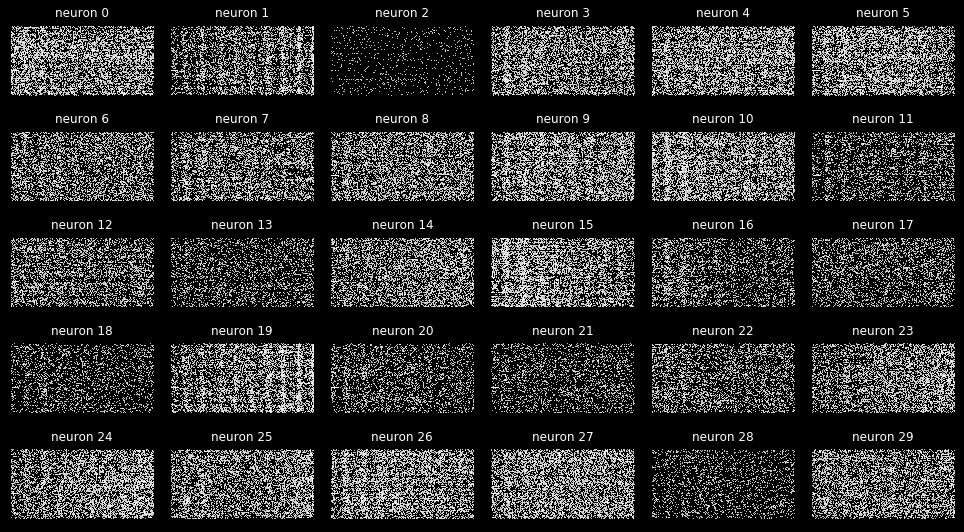

In [11]:
rasters(linear_aligned_data);

#### Visualize shift-aligned LFP

In [12]:
shift_aligned_lfp = shift_model.transform(lfp)[:, :, 0]
linear_aligned_lfp = lin_model.transform(lfp)[:, :, 0]

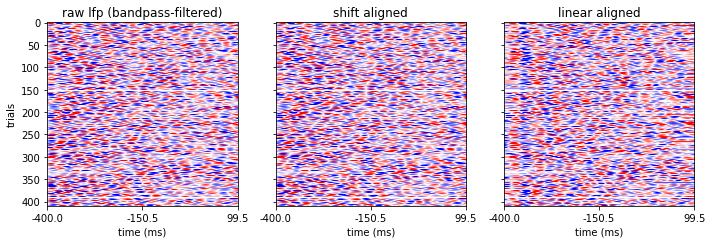

In [13]:
imkw = dict(clim=(-2, 2), cmap='bwr', interpolation="none", aspect="auto")

fig, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 3.5))

axes[0].imshow(lfp, **imkw)
axes[1].imshow(shift_aligned_lfp, **imkw)
axes[2].imshow(linear_aligned_lfp, **imkw)

axes[0].set_title("raw lfp (bandpass-filtered)")
axes[1].set_title("shift aligned")
axes[2].set_title("linear aligned")

axes[0].set_ylabel("trials")

for ax in axes:
    i = np.linspace(0, lfp_time.size - 1, 3).astype(int)
    ax.set_xticks(i)
    ax.set_xticklabels(lfp_time[i])
    ax.set_xlabel("time (ms)")

fig.tight_layout()

### Are oscillations visible in the population firing rate?

Since all multiunits oscillate in-phase, you can also see hints of oscillations in single-trial raster plots. Time warping makes it easier to visualize these oscillations by aligning them over many trials.

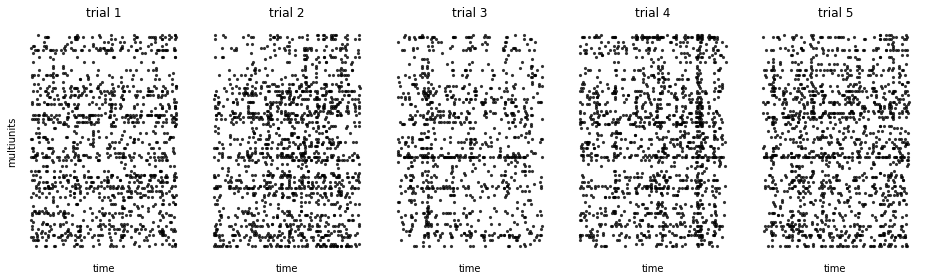

In [14]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(13, 4))

kw = dict(s=10, lw=0, color='k', alpha=.8)

prm = np.random.permutation(data.n_trials)

for k, ax in enumerate(axes):
    idx = (cropped_data.trials == prm[k])
    ax.scatter(cropped_data.spiketimes[idx], cropped_data.neurons[idx], **kw)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("trial {}".format(k + 1))
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xlabel('time')

axes[0].set_ylabel("multiunits")

fig.tight_layout();

**Averaging across neurons.**
We show that oscillations can also occasionally seen in the population firing rate (found by averaging across neurons) on single trials. Again time warping makes it easier to see these effects.

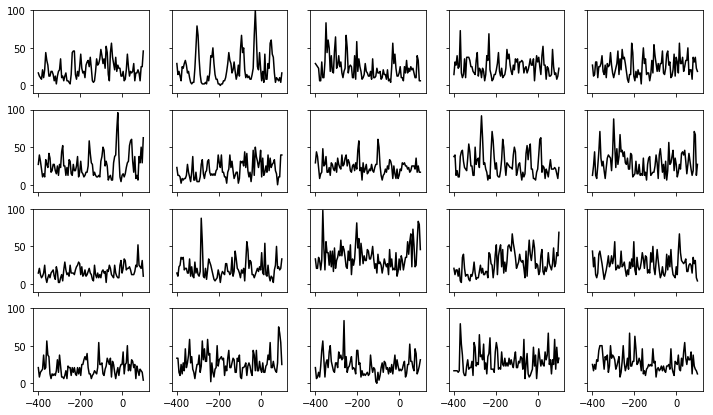

In [15]:
# Compute population firing rate.
pop_mean = data.bin_spikes(NBINS).mean(axis=2) / (BINSIZE * 1e-3)
tx = np.linspace(TMIN, TMAX, NBINS)

# Show 20 example trials.
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(12, 7))

for k, ax in enumerate(axes.ravel()):
    ax.plot(tx, pop_mean[5+k], "-k")
    ax.set_ylim([-10, 100])